In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score as CVS
from sklearn.preprocessing import PolynomialFeatures as PF
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse as RMSE
import scipy.stats as stats
import numbers
import pickle


In [5]:
def simple_selector(datass, x_cols, alpha=0.05):

    predictors = '+'.join(x_cols)
    f = 'price' + '~' + predictors
    results = ols(formula=f, data=datass).fit()
    pv = pd.DataFrame(results.pvalues).drop('Intercept')
    pv.rename(columns={0:'p_value'}, inplace=True)
    x_cols = list(pv[pv.p_value <= alpha].index)
    
    return x_cols, pv

In [6]:
def stepwise_selector(data, 
                       x_cols=[], 
                       alpha=0.05, 
                       verbose=False):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        x_cols - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    
    X = data[x_cols]
    y = data['price']
    threshold_in = alpha - 0.02
    threshold_out = alpha + 0.01
    included = list(x_cols)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            results = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = results.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        results = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = results.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
            
    pv = pd.DataFrame(results.pvalues)
    pv.rename(columns={0:'p_value'}, inplace=True)
    return included, pv

## Multicollinearity Function: Remove    
The first multicollinearity function removes a feature from each pair with high multicollinearity    
This function takes in thedata, x_cols and the threshold for removing a feature

- create a dataframe of the correlation of the features in x_cols   
- transform this to get a list of pairs of features with high multicollinearity
- for each pair: check whether they are the same feature or if one of the features has already been listed to be removed; if so, continue to next pair 
- otherwise add the feature with the higher p-value to a list    
- remove the features in this list from x_cols    


return x_cols     




In [7]:
def multicoll_remove(data, x_cols, pvalues, multicollinearity_threshold):
    corr = data[x_cols].corr().abs().stack().reset_index().sort_values(0,
                                                            ascending = False)
    corr['pairs'] = list(zip(corr.level_0, corr.level_1))
    corr = corr.set_index('pairs').drop(['level_0', 'level_1'], axis=1)
    corr.columns = ['cc']
    corr = corr[corr.cc > multicollinearity_threshold]        

    to_drop = []
    for f0, f1 in corr.index:
        if (f0 == f1) | any(feat in [f0, f1] for feat in to_drop):
            continue
        to_drop.append(pvalues.loc[[f0, f1]].sort_values('p_value', 
                                                ascending=False).index[0])
    x_cols = list(set(x_cols) - set(to_drop))
    return x_cols   

In [8]:
def transform(data, poly=None, test=False):
    """
    poly values: 'all', 'list', 'singles', 'all_single'
    Note: singles/all_single -column names only have first letters
    
    """
    data_t = data.copy()
    
#     'bathroomsx4', 'bedrooms', 'condition', 'date', 'floorsx2', 'grade', 'lat',
#        'long', 'price', 'sqft_above', 'sqft_basement', 'sqft_living',
#         'sqft_living15', 'sqft_lot', 'sqft_lot15', 'view', 'waterfront',
#         'yr_built', 'yr_renovated', 'zipcode'
    
    to_poly = ['price', 'sqft_above', 'sqft_basement', 'sqft_living',
              'sqft_living15', 'sqft_lot', 'sqft_lot15','yr_built', 
              'yr_renovated',]
    to_log = ['price', 'sqft_above', 'sqft_basement', 'sqft_living',
              'sqft_living15', 'sqft_lot', 'sqft_lot15','yr_built', 
              'yr_renovated',]
    to_norm = ['price', 'sqft_above', 'sqft_basement', 'sqft_living',
              'sqft_living15', 'sqft_lot', 'sqft_lot15','yr_built', 
              'yr_renovated',]
    to_ohe = ['bedrooms', 'bathroomsx4','condition', 'floorsx2','grade','view',]
    poly_order = 2

    if poly in ['all', 'all_single']:
        to_poly = data_t.drop(to_ohe + ['price','date'], axis=1).columns
        if poly == 'all':
            poly = 'list'
        else:
            poly = 'singles'
    if poly == 'list':
        poly=PF(poly_order)
        data_poly = poly.fit_transform(data_t[to_poly])
        data_poly = pd.DataFrame(data_poly)
        data_poly.columns = poly.get_feature_names(data_t[to_poly].columns)
        data_t = pd.concat([data_t.drop(to_poly, axis=1),data_poly.drop('1',axis=1)], axis=1)
    elif poly == 'singles':
        for feat in to_poly:
            df = pd.DataFrame(data_t[feat])
            poly=PF(poly_order)
            data_poly = poly.fit_transform(df)
            data_poly = pd.DataFrame(data_poly)
            data_poly.columns = ['drop', feat, feat + '_squared']
            data_t = pd.concat([data_t.drop(feat, axis=1), 
                                data_poly.drop('drop',axis=1)], axis=1)

    for feat in to_log:
        data_t[feat] = data_t[feat].map(lambda x: np.log(x) if x!=0 else 0)
        #Note 'if' included so that 0 values wouldn't error, will still error
        #...between 0 and 1. Also, implies that the original 0 value was a 1
        #...but as these are around values of 100s, 1000s, the effect is minimal

        
    stats = {}
    if test:
        with open('norm_stats.pickle', 'rb') as f:
            stats = pickle.load(f)
    for feat in to_norm:
        ft = data_t[feat]
        if test:
            mean = stats[feat][0]
            stdev = stats[feat][1]
        else:
            mean = np.mean(ft)
            stdev = np.sqrt(np.var(ft))
        data_t[feat] = (ft-mean) / stdev
        stats[feat] = [mean, stdev]
    with open('norm_stats.pickle', 'wb') as f:
        pickle.dump(stats, f)
        
        
    for feat in to_ohe:
        
        dummies = pd.get_dummies(data=data_t[feat], prefix=feat, prefix_sep='_',
                                drop_first=True)
        data_t.drop(feat, axis=1, inplace=True)
        data_t = pd.concat([data_t, dummies], axis=1)
    
    return data_t 

#Note data_t = data.copy()   --line added as otherwise the DataFrame, data, 
#...outside of this function lost the first column mentioned in [to_ohe]

In [9]:
def metrics(data, results, x_cols):
    X = data[x_cols]
    y = data.price
#     to_pred = pd.concat([y,X], axis=1)
#     yhat = results.predict(to_pred)
#     rmse = RMSE(y, yhat)
    
    linreg = LR()
    linreg.fit(X,y)
    cv  = np.mean(CVS(linreg, X, y, cv=5,  scoring='neg_mean_squared_error'))
    rmse = (-cv)**0.5
      
#     print(f'RMSE: {rmse}')
    
    fig = sm.graphics.qqplot(results.resid, dist=stats.norm, line='45',
                             fit=True, alpha=0.1)

    fig = plt.figure(figsize=(12,12))
    plt.scatter(data.price, results.resid, alpha=0.5);
    plt.hlines(0, xmax=data.price.max(), xmin=data.price.min());    

## Modelling Function
Takes in the dataframe and optional transform and multicollinearity arguments    
Checks whether to send the data to a transform function   
Selects for x_cols the features from data that are numeric, and not the price   
##### Loop

**1. Remove features with high p-values:**  
- creates the formula using x_cols     
- creates the model using formula   
- creates a dataframe, pv, of the model's p-values  
- creates a new x_cols list from the features in pv with low p-values   

**2. Handle multicollinearity:**     
- Checks whether a function has been passed for handling multicollinearity and calls accordingly    
    
         
            
            
Checks whether the length of x_cols has changed. Loop runs again if it has.     
    
    
When x_cols no longer changes, the final model and x_cols are returned





In [10]:
def modelling(datam, selector=simple_selector, transform=None, multicoll=None, 
              alpha=0.05, 
              multicollinearity_threshold = 0.7):
    
    if transform:
        datam = transform(datam)
        
    outcome = 'price'
    x_cols = [col for col in (datam.drop([outcome], axis=1).columns) 
            if isinstance(datam[col][0], numbers.Number)]
    i = 0
    while True:
        length0 = len(x_cols)
        print(f'Loop:{i}\nNumber of features: {length0}')
        
        x_cols, pvalues = selector(datam, x_cols, alpha)
        length1 = length0-len(x_cols)
        print(f'Removed by Selector: {length1}')
        
        if not i and multicoll:
            x_cols = multicoll(datam, x_cols, pvalues, 
                                      multicollinearity_threshold)
            length2 = length0 - length1 - len(x_cols)
            print(f'Removed for multicollinearity: {length2}')
        
        
        i+=1
        if len(x_cols) == length0:
            break
        
    predictors = '+'.join(x_cols)
    f = 'price' + '~' + predictors
    results = ols(formula=f, data=datam).fit()

    metrics(datam, results, x_cols)
    
    return results, x_cols

## Initial Model

Initial model using only cleaned data:

In [12]:
data = pd.read_csv('data/clean.csv')
data.sort_index(axis=1, inplace=True)
data_train, data_test = tts(data, train_size=0.8, random_state=111)

Loop:0
Number of features: 18
Removed by Selector: 2
Loop:1
Number of features: 16
Removed by Selector: 0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     2481.
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:52:11   Log-Likelihood:            -2.3159e+05
No. Observations:               16987   AIC:                         4.632e+05
Df Residuals:                   16970   BIC:                         4.633e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.309e+07   3.27e+06      3.999      0.000    6.67e+06    1.95e+07
bathroomsx4    1.107e+04    899.346     12.307      0.000    9305.185    1.28e+04
bedrooms      -4.172e+04   2230.985    -18.699      0.000   -4.61e+04   -3.73e+04
condition      2.687e+04   2657.168     10.113      0.000    2.17e+04    3.21e+04
grade          9.641e+04   2454.954     39.271      0.000    9.16e+04    1.01e+05
lat            6.052e+05   1.21e+04     49.816      0.000    5.81e+05    6.29e+05
long          -1.982e+05   1.52e+04    -13.023      0.000   -2.28e+05   -1.68e+05
sqft_above       93.4993     20.467      4.568      0.000      53.382     133.616
sqft_basement    64.3188     20.413      3.151      0.002      24.308     104.330
sqft_living      96.2041     20.521      4.688      0.000      55.981     136.427
sqft_living15    21.1323      3.945      5.357      0.000      13.400      28.864
sqft_lot15       -1.3133      0.169     -7.769      0.000      -1.645      -0.982
view           5.128e+04   2443.710     20.986      0.000    4.65e+04    5.61e+04
waterfront     6.636e+05   2.01e+04     32.932      0.000    6.24e+05    7.03e+05
yr_built      -3232.0176    141.714    -22.807      0.000   -3509.792   -2954.243
yr_renovated    574.1015    145.970      3.933      0.000     287.986     860.217
zipcode        -627.3845     36.934    -16.987      0.000    -699.779    -554.990
==============================================================================
Omnibus:                    13803.971   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1108358.870
Skew:                           3.379   Prob(JB):                         0.00
Kurtosis:                      41.991   Cond. No.                     2.09e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

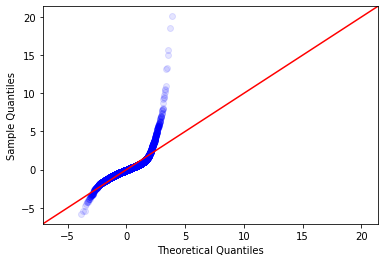

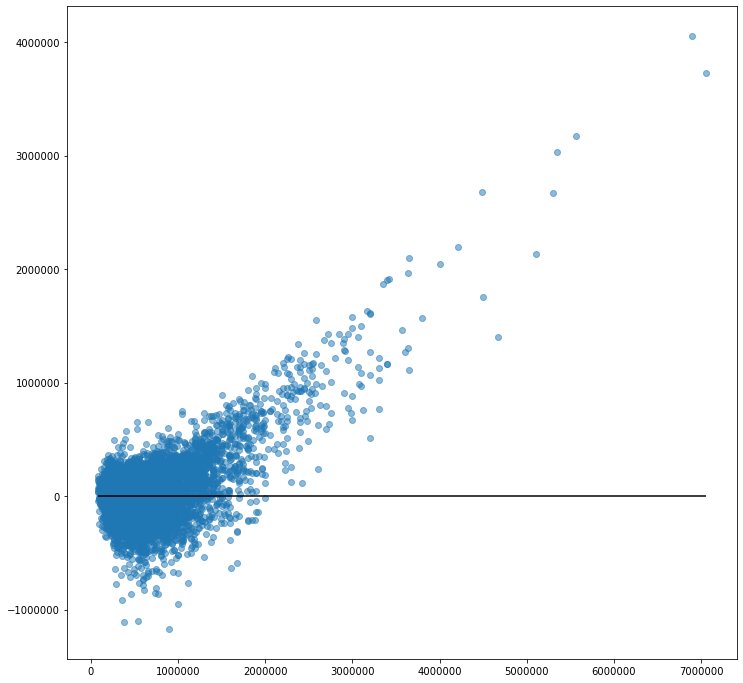

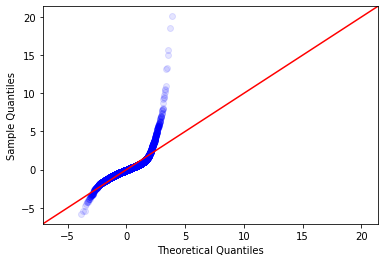

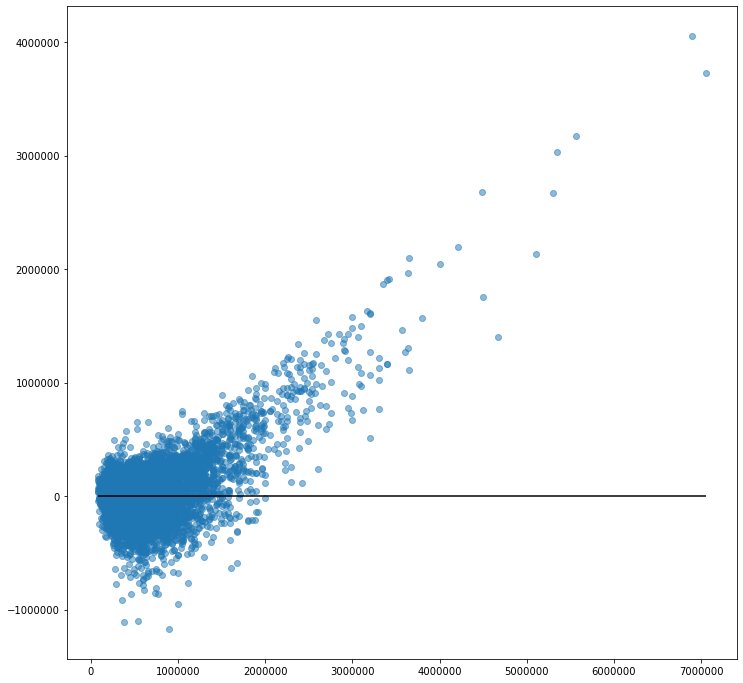

In [13]:
results, x_cols = modelling(data_train)
metrics(data_train, results, x_cols)
results.summary()

Loop:0
Number of features: 18


/Users/taejoon/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Removed by Selector: 2
Removed for multicollinearity: 4
Loop:1
Number of features: 12
Removed by Selector: 2
Loop:2
Number of features: 10
Removed by Selector: 0


KeyError: "['condition', 'view', 'grade', 'bathroomsx4'] not in index"

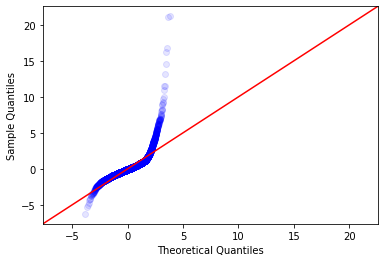

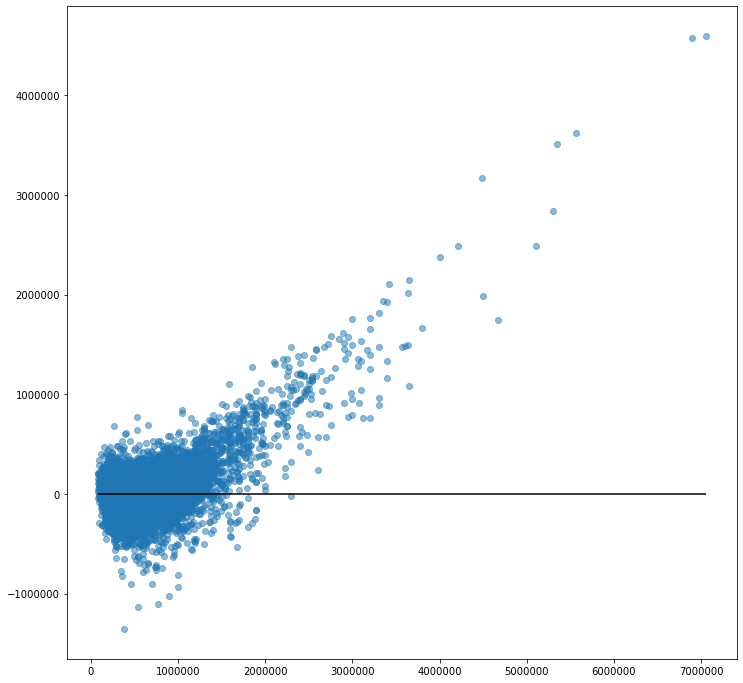

In [14]:
# Model with stepwise selection and removing multicollinear features
results, x_cols = modelling(data_train, selector=stepwise_selector, 
                            multicoll=multicoll_remove)

metrics(transform(data_train), results, x_cols)
results.summary()


In [15]:
to_poly = ['price', 'sqft_above', 'sqft_basement', 'sqft_living',
          'sqft_living15', 'sqft_lot', 'sqft_lot15','yr_built', 
          'yr_renovated',]
to_log = ['price', 'sqft_above', 'sqft_basement', 'sqft_living',
          'sqft_living15', 'sqft_lot', 'sqft_lot15','yr_built', 
          'yr_renovated',]
to_norm = ['price', 'sqft_above', 'sqft_basement', 'sqft_living',
          'sqft_living15', 'sqft_lot', 'sqft_lot15','yr_built', 
          'yr_renovated',]
to_ohe = ['bedrooms', 'bathroomsx4','condition', 'floorsx2','grade','view',]


Loop:0
Number of features: 72
Removed by Selector: 14
Removed for multicollinearity: 5
Loop:1
Number of features: 53
Removed by Selector: 5
Loop:2
Number of features: 48
Removed by Selector: 0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     840.0
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:52:26   Log-Likelihood:                -13758.
No. Observations:               16987   AIC:                         2.761e+04
Df Residuals:                   16938   BIC:                         2.799e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -32.2251      8.891     -3.624      0.000     -49.652     -14.798
view_2             0.3233      0.021     15.606      0.000       0.283       0.364
waterfront         0.8011      0.062     12.932      0.000       0.680       0.922
bathroomsx4_20     1.5330      0.139     11.017      0.000       1.260       1.806
long              -0.3225      0.040     -7.985      0.000      -0.402      -0.243
bathroomsx4_17     1.3198      0.074     17.762      0.000       1.174       1.465
floorsx2_5         0.5869      0.053     11.151      0.000       0.484       0.690
bathroomsx4_9      0.3246      0.020     15.867      0.000       0.285       0.365
bathroomsx4_14     0.9310      0.031     30.030      0.000       0.870       0.992
grade_5           -0.5110      0.041    -12.510      0.000      -0.591      -0.431
yr_built          -0.1521      0.007    -22.444      0.000      -0.165      -0.139
bathroomsx4_24     2.0369      0.252      8.087      0.000       1.543       2.531
bathroomsx4_5      0.4123      0.193      2.132      0.033       0.033       0.791
lat                2.9077      0.033     88.693      0.000       2.843       2.972
floorsx2_4         0.3081      0.013     23.175      0.000       0.282       0.334
bathroomsx4_23     1.1516      0.324      3.553      0.000       0.516       1.787
floorsx2_6         0.4856      0.029     16.558      0.000       0.428       0.543
condition_4        0.1026      0.011      9.707      0.000       0.082       0.123
bedrooms_6        -0.1634      0.040     -4.130      0.000      -0.241      -0.086
view_1             0.3563      0.035     10.066      0.000       0.287       0.426
bedrooms_4         0.0309      0.013      2.416      0.016       0.006       0.056
bathroomsx4_13     0.8810      0.033     26.967      0.000       0.817       0.945
bathroomsx4_7      0.2344      0.017     14.192      0.000       0.202       0.267
bathroomsx4_8      0.2916      0.018     15.943      0.000       0.256       0.327
bathroomsx4_26     2.2891      0.388      5.895      0.000       1.528       3.050
sqft_basement      0.0620      0.005     11.978      0.000       0.052       0.072
grade_13           1.2996      0.207      6.271      0.000       0.893       1.706
bathroomsx4_31     2.3377      0.586      3.989      0.000       1.189       3.486
bathroomsx4_25     3.1493      0.545      5.775      0.000       2.080       4.218
grade_4           -0.9496      0.117     -8.122      0.000      -1.179      -0.720
grade_12           0.7238      0.074      9.827      0.000       0.579       0.868
bathroomsx4_11     0.5096      0.024     20.903      0.000       0.462       0.557
bedrooms_3        -0.0365      0.012     -3.150      0.002      -0.059      -0.014
bathroomsx4_10     0.4055      0.019     20.991      0.000       0.368       0.443
bathroomsx4_

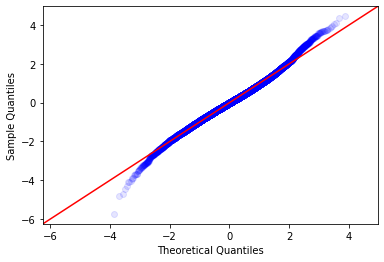

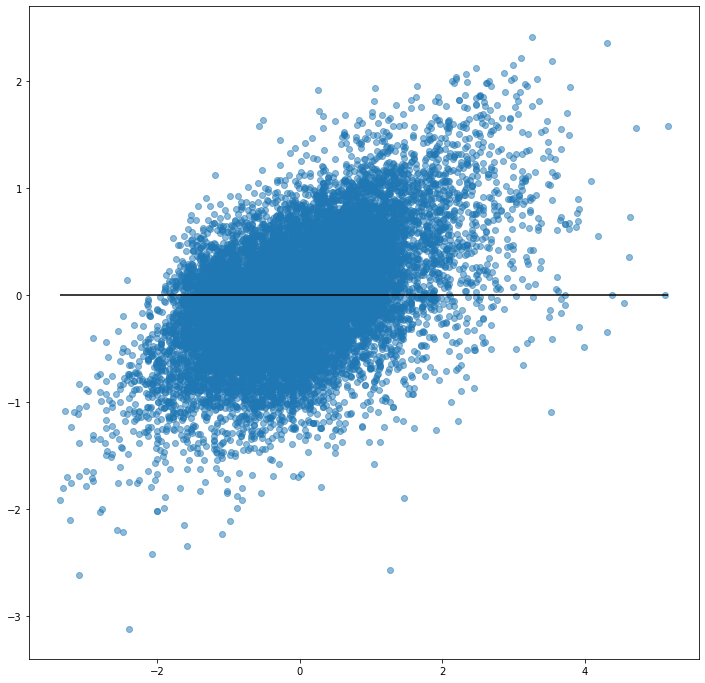

In [16]:
results, x_cols = modelling(data_train, transform=transform, 
                            selector=simple_selector,multicoll=multicoll_remove)

# metrics(data_train, results, x_cols)
results.summary()

In [17]:
data.columns

Index(['bathroomsx4', 'bedrooms', 'condition', 'date', 'floorsx2', 'grade',
       'lat', 'long', 'price', 'sqft_above', 'sqft_basement', 'sqft_living',
       'sqft_living15', 'sqft_lot', 'sqft_lot15', 'view', 'waterfront',
       'yr_built', 'yr_renovated', 'zipcode'],
      dtype='object')

In [18]:
data_t = transform(data,poly='all')
outcome = 'price'
x_cols = [col for col in (data_t.drop([outcome], axis=1).columns) 
            if isinstance(data_t[col][0], numbers.Number)]

x_cols, pvalues = simple_selector(data_t, x_cols)

SyntaxError: invalid syntax (<unknown>, line 1)

In [ ]:
for col in data_t:
    print(col)